In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns
import warnings
import sklearn
import pickle
from collections import defaultdict
from imblearn.datasets import make_imbalance
warnings.filterwarnings('ignore')


## Data Preprocessing
### Detect and crop faces

In [2]:
emo_dict = dict(zip(['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],range(8)))
label_dict = dict(zip(range(8), ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']))
emo_dict

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [3]:
df = pd.read_csv('./data/raw/labels.csv')
df = df.rename({'pth': 'path'}, axis=1)
df = df.loc[df.label.isin(['anger', 'happy', 'neutral', 'sad', 'surprise'])].reset_index(drop=True)
df.path = './data/raw/' + df.path
df.head()

,path,label
0,./data/raw/anger/image0000006.jpg,surprise
1,./data/raw/anger/image0000007.jpg,anger
2,./data/raw/anger/image0000012.jpg,anger
3,./data/raw/anger/image0000060.jpg,anger
4,./data/raw/anger/image0000061.jpg,anger


Emotion: anger


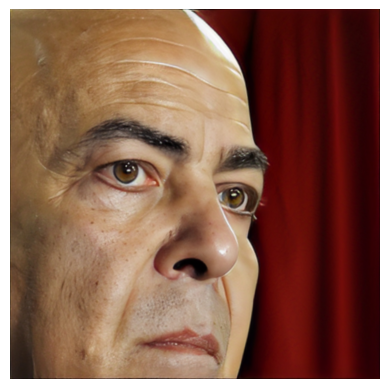

In [4]:
# Display the 1000th image in the dataframe
img_bgr = cv2.imread(df.path[999])
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print(f'Emotion: {df.label[999]}')
plt.imshow(img_rgb)
plt.axis('off');

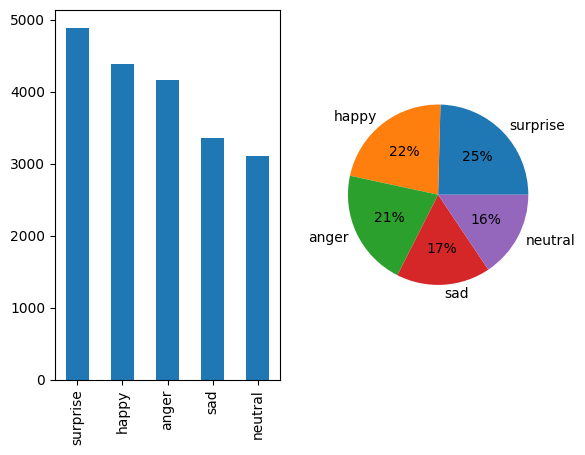

In [5]:
fig,ax = plt.subplots(nrows=1,ncols=2)
df.label.value_counts().plot(kind='bar',ax=ax[0])
df.label.value_counts().plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.axis('off')
plt.show()

In [6]:
cropped_df = pd.DataFrame(columns=['path', 'label', 'dimension'])
for i in range(len(df)):
    try:
        img_bgr = cv2.imread(df.path[i])
        # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        faces = haar.detectMultiScale(img_gray, 1.5, 5)
        for x,y,w,h in faces:
            cv2.rectangle(img_bgr, (x,y), (x+w,y+h), (0,0,255),1)
            roi = img_bgr[y:y+h, x:x+w]
            cv2.imwrite(f'./data/cropped/{df.label[i]}_{i}.jpg',roi)
            cropped_df = cropped_df.append({'path': f'./data/cropped/{df.label[i]}_{i}.jpg', 'label': df.label[i], 'dimension': roi.shape[0]}, ignore_index=True)
    except:
        continue
    

### Resize the images
#### Exploratory Data Analysis

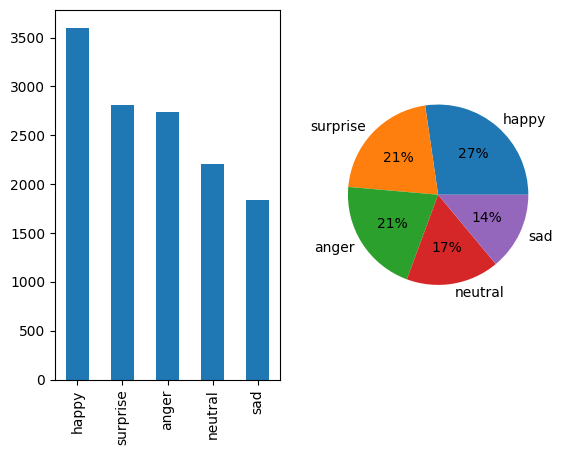

In [27]:
fig,ax = plt.subplots(nrows=1,ncols=2)
cropped_df.label.value_counts().plot(kind='bar',ax=ax[0])
cropped_df.label.value_counts().plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.axis('off')
plt.show()

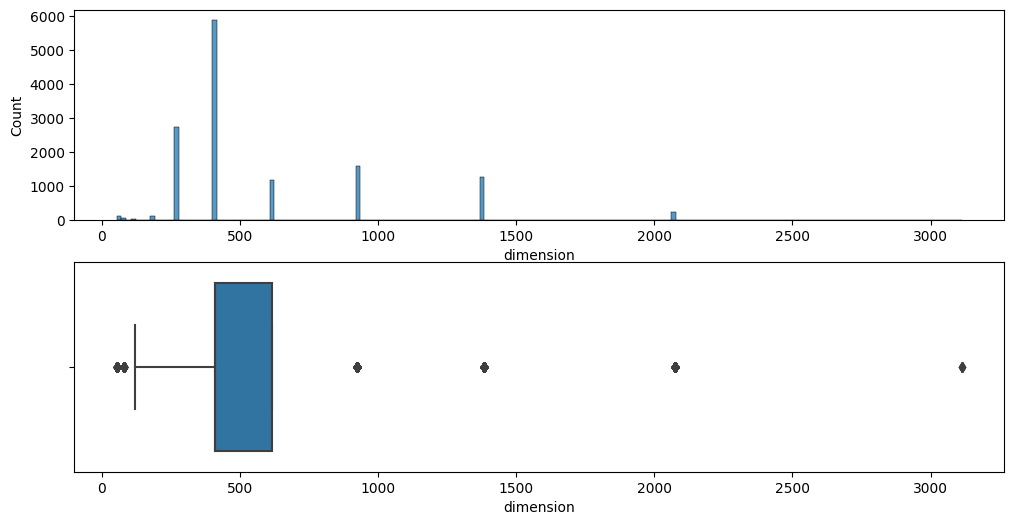

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
sns.histplot(cropped_df['dimension'])
plt.subplot(2,1,2)
sns.boxplot(cropped_df['dimension'])
plt.show()

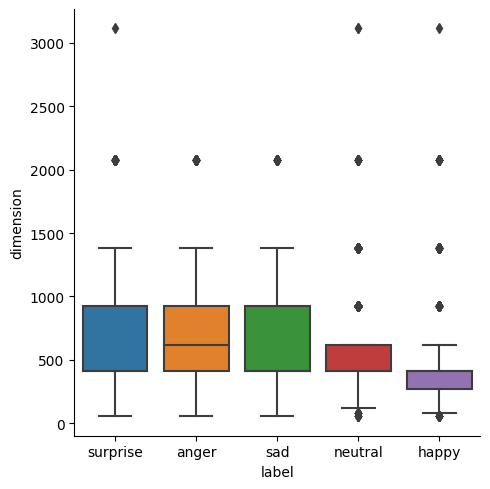

In [9]:
sns.catplot(data=cropped_df,x='label',y='dimension',kind='box');

In [29]:
filtered = cropped_df[cropped_df.dimension >= 80]
filtered.label.value_counts()

happy       3583
surprise    2790
anger       2715
neutral     2193
sad         1810
Name: label, dtype: int64

In [11]:
paths = filtered.path
y = filtered.label
paths, y = make_imbalance(np.array(paths).reshape(-1, 1), y,
                               sampling_strategy=dict(zip(filtered.label.value_counts().index, [1800 for i in range(8)])),
                               random_state=42)
paths = paths.flatten()

In [12]:
paths.shape, y.shape

((9000,), (9000,))

In [13]:
y.value_counts()

anger       1800
happy       1800
neutral     1800
sad         1800
surprise    1800
Name: label, dtype: int64

In [14]:
balanced = pd.concat([pd.Series(paths), y], axis=1).rename({0: 'path'}, axis=1)

#### Resize all the the image into 100 x 100 and flatten

In [15]:
def resize_img(path):
    try:
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dim = len(img_gray)
        if dim <= 150:
            # INTER_AREA is for shrink
            img_gray = cv2.resize(img_gray, (100,100), cv2.INTER_AREA)
        else:
            # INTER_CUBIC is for enlarging
            img_gray = cv2.resize(img_gray, (100,100), cv2.INTER_CUBIC)
        
        return img_gray.flatten()
    
    except:
        return None
        

        

In [16]:
balanced['img'] = balanced['path'].apply(resize_img)

[ WARN:0@1708.989] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/cropped/neutral_212.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1709.628] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/cropped/neutral_305.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1710.913] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/cropped/neutral_215.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1710.963] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/cropped/neutral_272.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1711.232] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/lo

In [17]:
data = balanced['img'].apply(pd.Series)
data.columns = [f"pixel_{i}" for i in data.columns]
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9990,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999
0,101.0,80.0,126.0,126.0,135.0,129.0,129.0,149.0,137.0,126.0,...,11.0,9.0,8.0,10.0,11.0,12.0,11.0,14.0,13.0,13.0
1,115.0,116.0,117.0,62.0,36.0,46.0,26.0,48.0,21.0,27.0,...,26.0,23.0,21.0,22.0,22.0,22.0,21.0,21.0,26.0,21.0
2,118.0,113.0,85.0,116.0,90.0,121.0,72.0,82.0,23.0,41.0,...,29.0,30.0,31.0,30.0,28.0,28.0,24.0,108.0,169.0,183.0
3,21.0,16.0,28.0,15.0,47.0,25.0,29.0,29.0,30.0,19.0,...,9.0,10.0,12.0,13.0,12.0,15.0,20.0,58.0,62.0,59.0
4,7.0,6.0,8.0,4.0,5.0,5.0,8.0,103.0,70.0,66.0,...,89.0,79.0,101.0,104.0,98.0,87.0,92.0,83.0,37.0,34.0


### Data Normalization

In [18]:
data = data/255.0 
data['label'] = balanced.label
data.dropna(inplace=True)
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,label
0,0.396078,0.313725,0.494118,0.494118,0.529412,0.505882,0.505882,0.584314,0.537255,0.494118,...,0.035294,0.031373,0.039216,0.043137,0.047059,0.043137,0.054902,0.050980,0.050980,anger
1,0.450980,0.454902,0.458824,0.243137,0.141176,0.180392,0.101961,0.188235,0.082353,0.105882,...,0.090196,0.082353,0.086275,0.086275,0.086275,0.082353,0.082353,0.101961,0.082353,anger
2,0.462745,0.443137,0.333333,0.454902,0.352941,0.474510,0.282353,0.321569,0.090196,0.160784,...,0.117647,0.121569,0.117647,0.109804,0.109804,0.094118,0.423529,0.662745,0.717647,anger
3,0.082353,0.062745,0.109804,0.058824,0.184314,0.098039,0.113725,0.113725,0.117647,0.074510,...,0.039216,0.047059,0.050980,0.047059,0.058824,0.078431,0.227451,0.243137,0.231373,anger
4,0.027451,0.023529,0.031373,0.015686,0.019608,0.019608,0.031373,0.403922,0.274510,0.258824,...,0.309804,0.396078,0.407843,0.384314,0.341176,0.360784,0.325490,0.145098,0.133333,anger


In [19]:
data.label.unique()

array(['anger', 'happy', 'neutral', 'sad', 'surprise'], dtype=object)

### Save the data

In [20]:
import pickle
pickle.dump(data, open('./data/cropped_100*100.pickle', mode='wb'))

### Eigen Face using PCA

In [21]:
data = pickle.load(open('./data/cropped_100*100.pickle',mode='rb'))

In [22]:
X = data.drop('label', axis=1).values
y = data['label'].replace(emo_dict).values.astype(int)

In [23]:
X.shape, y.shape

((8964, 10000), (8964,))

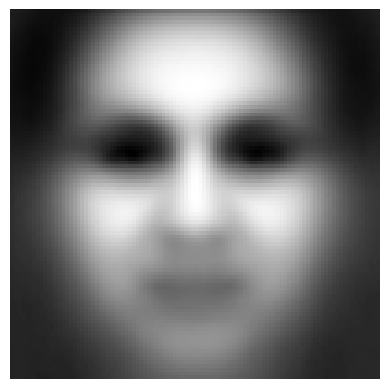

In [24]:
mean_face = X.mean(axis=0)
X = X - mean_face
plt.imshow(mean_face.reshape((100,100)),cmap='gray')
plt.axis('off')
plt.show()

In [42]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=None,whiten=True,svd_solver='auto')
pca.fit(X)

PCA(whiten=True)

In [43]:
exp_var = pd.DataFrame()
exp_var['explained_variance'] = pca.explained_variance_ratio_
exp_var['cumulative_explained_variance'] = exp_var['explained_variance'].cumsum()
exp_var['principal_components'] = np.arange(1,len(exp_var)+1)

exp_var.head()

,explained_variance,cumulative_explained_variance,principal_components
0,0.234244,0.234244,1
1,0.105609,0.339853,2
2,0.096864,0.436717,3
3,0.049712,0.486429,4
4,0.034744,0.521173,5


In [49]:
exp_var[exp_var['cumulative_explained_variance'] > 0.83] # Principle components that contribute over 80% of the explained variance

,explained_variance,cumulative_explained_variance,principal_components
74,1.068227e-03,0.830866,75
75,1.061630e-03,0.831927,76
76,1.030230e-03,0.832958,77
77,1.014905e-03,0.833973,78
78,1.013277e-03,0.834986,79
...,...,...,...
14395,1.385878e-35,1.000000,14396
14396,9.298543e-36,1.000000,14397
14397,5.967115e-36,1.000000,14398
14398,5.342706e-36,1.000000,14399


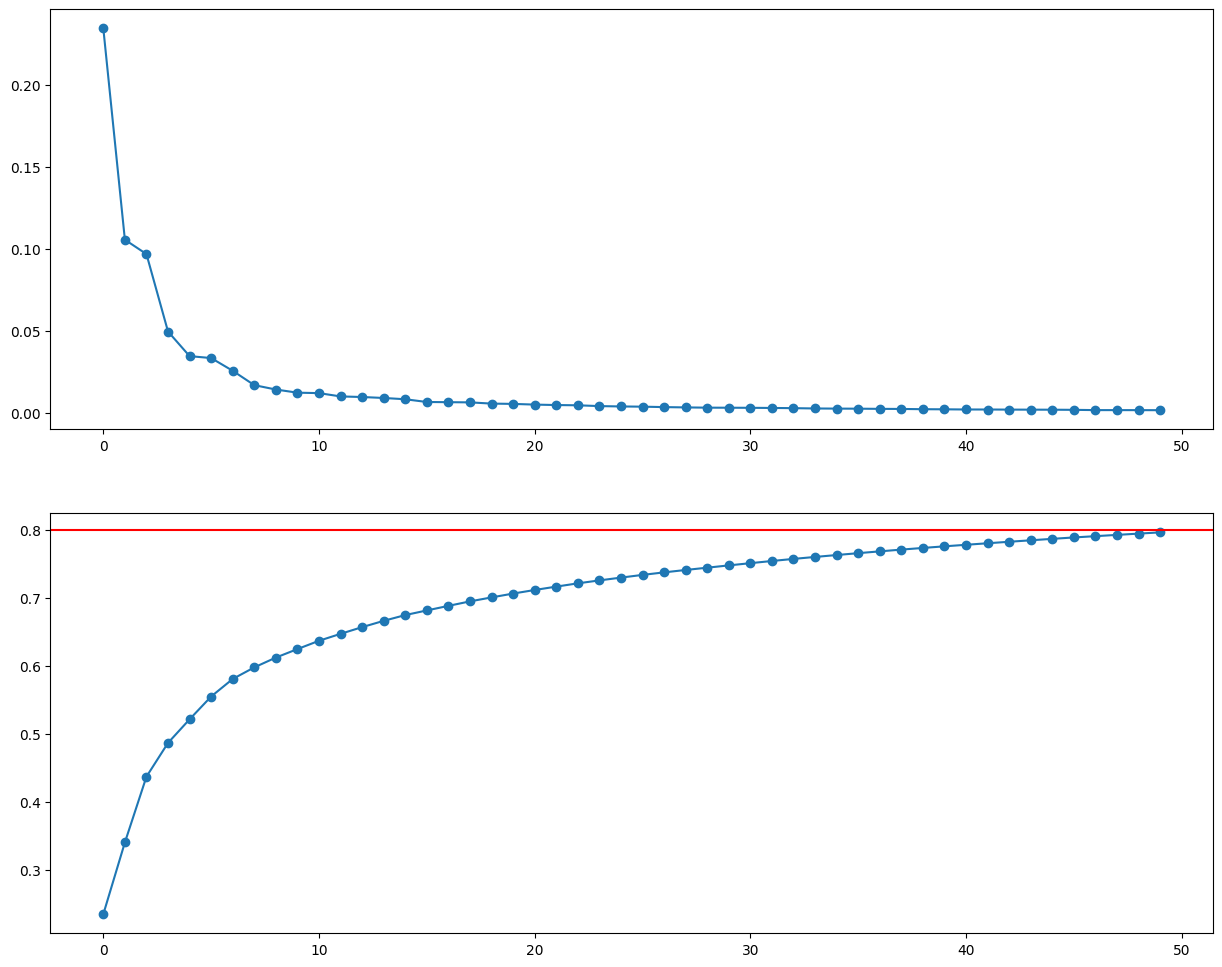

In [45]:
fig, ax = plt.subplots(nrows=2,figsize=(15,12))

exp_var['explained_variance'].head(50).plot(kind='line',marker='o',ax=ax[0])
exp_var['cumulative_explained_variance'].head(50).plot(kind='line',marker='o',ax=ax[1])
plt.axhline(y = 0.8, color = 'r', linestyle = '-')


50 pricipal components cover 80% of the explained variance.

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50,whiten=True,svd_solver='auto')
X_pca = pca.fit_transform(X)

In [ ]:
X_pca.shape

(9000, 50)

In [37]:
# Visualize Eigen Image
pca_inv = pca.inverse_transform(X_pca)
pca_inv.shape

(8964, 10000)

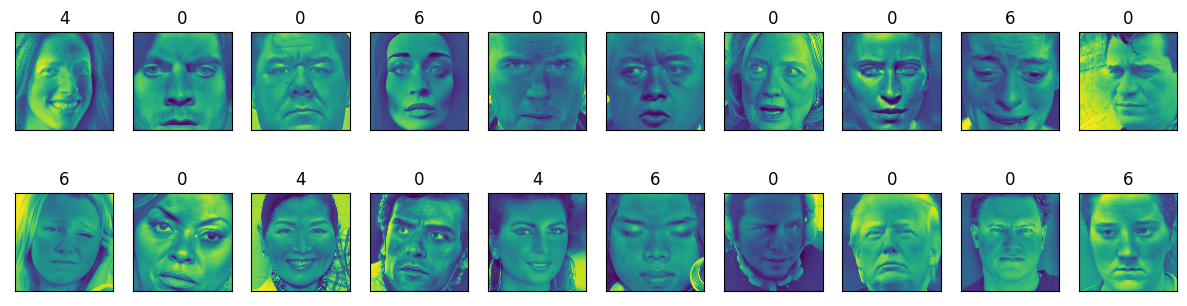

====================Eigen Images====================


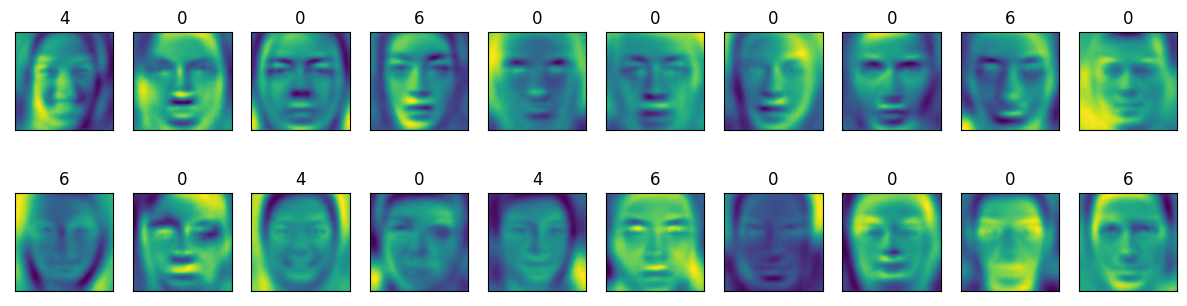

In [38]:
np.random.seed(1001)
pics = np.random.randint(0,len(X_pca),20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    
    img = X[pic].reshape(100,100)
    plt.imshow(img)
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
plt.show()

print("="*20+'Eigen Images'+"="*20)
plt.figure(figsize=(15,8))
for i,pic in enumerate(pics):
    plt.subplot(4,10,i+1)
    img = pca_inv[pic].reshape(100,100)
    plt.imshow(img)
    plt.title('{}'.format(y[pic]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [39]:
# saving data and models
np.savez('./data/data_pca_50_target', X, y.astype(int))

pickle.dump({'pca':pca,'mean_face':mean_face}, open('model/pca_mean_face.pickle','wb'))

## SVC and grid search

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [41]:
X_train,X_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.2, stratify = y) #stratify = y

In [92]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [96]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

In [47]:
# Fitting SVM model
svc = SVC(probability=True)
param_grid = {'C':[0.5,1,10,20,30,50],
             'kernel':['rbf'],
             'gamma':[0.1,0.05,0.01,0.001,0.002,0.005],
             'coef0':[0,1]}
model_grid = GridSearchCV(svc,
                          param_grid=param_grid,
                          scoring='accuracy',cv=3,verbose=2)
model_grid.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=  17.1s
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=  16.9s
[CV] END ..............C=0.5, coef0=0, gamma=0.1, kernel=rbf; total time=  16.6s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=  15.8s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=  15.8s
[CV] END .............C=0.5, coef0=0, gamma=0.05, kernel=rbf; total time=  15.8s
[CV] END .............C=0.5, coef0=0, gamma=0.01, kernel=rbf; total time=  13.2s
[CV] END .............C=0.5, coef0=0, gamma=0.01, kernel=rbf; total time=  13.3s
[CV] END .............C=0.5, coef0=0, gamma=0.01, kernel=rbf; total time=  13.4s
[CV] END ............C=0.5, coef0=0, gamma=0.001, kernel=rbf; total time=  15.3s
[CV] END ............C=0.5, coef0=0, gamma=0.001, kernel=rbf; total time=  15.3s
[CV] END ............C=0.5, coef0=0, gamma=0.00

GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid={'C': [0.5, 1, 10, 20, 30, 50], 'coef0': [0, 1],
                         'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [54]:
model_grid.best_params_

{'C': 20, 'coef0': 0, 'gamma': 0.05, 'kernel': 'rbf'}

In [51]:
model_svc = model_grid.best_estimator_

In [52]:
pickle.dump(model_svc,open('./model/model_svc.pickle',mode='wb'))

In [53]:
metrics.accuracy_score(y_test, model_svc.predict(X_test))

0.5036252091466815

In [97]:
# Fitting Logistic Regression Model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
param_grid_lr = {'C':[0.001, 0.1,0.5,1,10,100,1000]}
model_grid_lr = GridSearchCV(lr,
                          param_grid=param_grid_lr,
                          scoring='accuracy',cv=3,verbose=2)
model_grid_lr.fit(X_train,y_train)
print(model_grid_lr.best_params_)
model_lr = model_grid_lr.best_estimator_

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ............................................C=0.001; total time=   0.1s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.0s
[CV] END ..............................................C=0.5; total time=   0.0s
[CV] END ................................................C=1; total time=   0.4s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ........................................

In [100]:
# Fitting ramdom forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
param_grid_rf = {'max_depth':[2, 3,4, 5, 6,7,8,9,10, 11], 'n_estimators': [5, 10, 20, 50, 100]}
model_grid_rf = GridSearchCV(rf,
                          param_grid=param_grid_rf,
                          scoring='accuracy',cv=3,verbose=2)
model_grid_rf.fit(X_train,y_train)
print(model_grid_rf.best_params_)
model_rf = model_grid_rf.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=2, n_

In [106]:
# Fitting Voting Classifier
model_vote = VotingClassifier(estimators=[('svm', model_svc),
                                         ('rf', model_rf),
                                         ('lr', model_lr),
                                         ('knn', knn)],
                                          voting = 'soft',)
grid_vote = GridSearchCV(model_vote, param_grid={'weights': [[1,1,1,1],
                                                             [2,1,1,1],
                                                             [3,1,1,1],
                                                             [1,1,1,0],
                                                             [2,1,2,1],
                                                             [2,1,2,0],
                                                             [2,2,1,0],
                                                             [2,2,1,1],
                                                             [4,1,1,0],
                                                             [4,1.5,1.5,1],]}, verbose = 4, cv=3)
grid_vote.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ..............weights=[1, 1, 1, 1];, score=0.487 total time=  18.5s
[CV 2/3] END ..............weights=[1, 1, 1, 1];, score=0.482 total time=  18.4s
[CV 3/3] END ..............weights=[1, 1, 1, 1];, score=0.485 total time=  18.4s
[CV 1/3] END ..............weights=[2, 1, 1, 1];, score=0.494 total time=  18.3s
[CV 2/3] END ..............weights=[2, 1, 1, 1];, score=0.494 total time=  18.3s
[CV 3/3] END ..............weights=[2, 1, 1, 1];, score=0.500 total time=  18.4s
[CV 1/3] END ..............weights=[3, 1, 1, 1];, score=0.504 total time=  18.4s
[CV 2/3] END ..............weights=[3, 1, 1, 1];, score=0.499 total time=  18.3s
[CV 3/3] END ..............weights=[3, 1, 1, 1];, score=0.502 total time=  18.3s
[CV 1/3] END ..............weights=[1, 1, 1, 0];, score=0.508 total time=  18.3s
[CV 2/3] END ..............weights=[1, 1, 1, 0];, score=0.513 total time=  18.4s
[CV 3/3] END ..............weights=[1, 1, 1, 0];

GridSearchCV(cv=3,
             estimator=VotingClassifier(estimators=[('svm',
                                                     SVC(C=20, coef0=0,
                                                         gamma=0.05,
                                                         probability=True)),
                                                    ('rf',
                                                     RandomForestClassifier(max_depth=11)),
                                                    ('lr',
                                                     LogisticRegression(C=0.1)),
                                                    ('knn',
                                                     KNeighborsClassifier())],
                                        voting='soft'),
             param_grid={'weights': [[1, 1, 1, 1], [2, 1, 1, 1], [3, 1, 1, 1],
                                     [1, 1, 1, 0], [2, 1, 2, 1], [2, 1, 2, 0],
                                     [2, 2, 1, 0], [2, 2, 1, 1], [4, 1, 1, 0],
                                     [4, 1.5, 1.5, 1]]},
             verbose=4)

In [108]:
grid_vote.best_estimator_, grid_vote.best_score_

(VotingClassifier(estimators=[('svm',
                               SVC(C=20, coef0=0, gamma=0.05, probability=True)),
                              ('rf', RandomForestClassifier(max_depth=11)),
                              ('lr', LogisticRegression(C=0.1)),
                              ('knn', KNeighborsClassifier())],
                  voting='soft', weights=[1, 1, 1, 0]),
 0.5074605666180768)

In [109]:
model_vote = grid_vote.best_estimator_

### Model Evaluation based on 2 metrics
- Classification Report
- Kappa Score

**Classification Report**

In [110]:
print('='*20 + " SVM classification report "+'='*20)
classification_report_svc = metrics.classification_report(y_test,model_svc.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_svc).T)
print('='*20 + " Ramdom Forest classification report "+'='*20)
classification_report_rf = metrics.classification_report(y_test,model_rf.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_rf).T)
print('='*20 + " Logitstic Regression classification report "+'='*20)
classification_report_lr = metrics.classification_report(y_test,model_lr.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_lr).T)
print('='*20 + " Voting Classifier classification report "+'='*20)
classification_report_vote = metrics.classification_report(y_test,model_vote.predict(X_test),output_dict=True)
display(pd.DataFrame(classification_report_vote).T)

==================== SVM classification report ====================


,precision,recall,f1-score,support
0,0.445328,0.622222,0.519119,360.000000
4,0.741641,0.677778,0.708273,360.000000
5,0.468750,0.420168,0.443131,357.000000
6,0.457627,0.378151,0.414110,357.000000
7,0.433526,0.417827,0.425532,359.000000
accuracy,0.503625,0.503625,0.503625,0.503625
macro avg,0.509374,0.503229,0.502033,1793.000000
weighted avg,0.509571,0.503625,0.502322,1793.000000


==================== Ramdom Forest classification report ====================


,precision,recall,f1-score,support
0,0.467337,0.516667,0.490765,360.00000
4,0.554839,0.716667,0.625455,360.00000
5,0.413043,0.319328,0.360190,357.00000
6,0.426667,0.358543,0.389650,357.00000
7,0.384181,0.378830,0.381487,359.00000
accuracy,0.458450,0.458450,0.458450,0.45845
macro avg,0.449213,0.458007,0.449509,1793.00000
weighted avg,0.449348,0.458450,0.449797,1793.00000


==================== Logitstic Regression classification report ====================


,precision,recall,f1-score,support
0,0.467005,0.511111,0.488064,360.000000
4,0.580135,0.713889,0.640100,360.000000
5,0.361217,0.266106,0.306452,357.000000
6,0.382979,0.352941,0.367347,357.000000
7,0.357143,0.362117,0.359613,359.000000
accuracy,0.441718,0.441718,0.441718,0.441718
macro avg,0.429696,0.441233,0.432315,1793.000000
weighted avg,0.429929,0.441718,0.432675,1793.000000


==================== Voting Classifier classification report ====================


,precision,recall,f1-score,support
0,0.522167,0.588889,0.553525,360.000000
4,0.648456,0.758333,0.699104,360.000000
5,0.480287,0.375350,0.421384,357.000000
6,0.460317,0.406162,0.431548,357.000000
7,0.446237,0.462396,0.454172,359.000000
accuracy,0.518684,0.518684,0.518684,0.518684
macro avg,0.511493,0.518226,0.511946,1793.000000
weighted avg,0.511667,0.518684,0.512265,1793.000000


**Kappa Score**

In [111]:
print('='*20 + " SVM Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_svc.predict(X_test)))
print('='*20 + " Ramdom Forest Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_rf.predict(X_test)))
print('='*20 + " Logistic Regression Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_lr.predict(X_test)))
print('='*20 + " Voting Classifier Kappa Score "+'='*20)
print(' ' * 20, metrics.cohen_kappa_score(y_test,model_vote.predict(X_test)))

==================== SVM Kappa Score ====================
                     0.3794544945480566
==================== Ramdom Forest Kappa Score ====================
                     0.32294918316545806
==================== Logistic Regression Kappa Score ====================
                     0.3020467748703194
==================== Voting Classifier Kappa Score ====================
                     0.39827137459007755


#### Save Model

In [112]:
import pickle
pickle.dump(model_svc,open('./model/model_svc.pickle',mode='wb'))
pickle.dump(model_lr ,open('./model/model_lr.pickle',mode='wb'))
pickle.dump(model_rf ,open('./model/model_rf.pickle',mode='wb'))
pickle.dump(model_vote ,open('./model/model_vote.pickle',mode='wb'))

### Pipeline

In [113]:
from emotion_recognition import pipeline, real_time
import matplotlib.pyplot as plt
import cv2

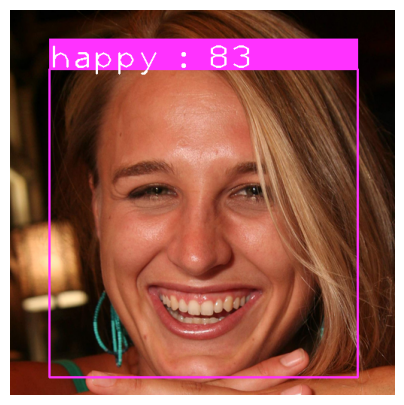

In [119]:
img_bgr = pipeline('./data/raw/happy/ffhq_0.png')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## Real Time Gender Recognition
- Given a path to a video, will predict on the video.
- Press 'q' to stop.

In [116]:
real_time('./data/test_images/video.mp4')

OpenCV: Couldn't read video stream from file "./data/test_images/video.mp4"


- Given no argument, will predict on video captured from camera.
- Similarly, press 'q' to stop.

In [118]:
real_time()